# CREATE DATASET OF ISOLATED CELLS

In [159]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import torch
import torchvision.transforms as transforms
import numpy
import skimage.filters
import skimage.exposure
import skimage.transform
import skimage.morphology
import PIL.Image
PIL.Image.MAX_IMAGE_PIXELS = None
from MODULES.namedtuple import ImageBbox, PreProcess, BB
from MODULES.utilities import save_obj, load_obj, load_json_as_dict, show_batch
from MODULES.cropper_uncropper import Cropper

### Helper function

In [2]:
def img_pre_processing(pilfile, reduction_factor=1, remove_background=True):
    """ Resize and rescale intensities in (0,1) """
    
    # Open and resize using bilinear interpolation
    w_raw, h_raw = pilfile.size
    w_new = int(w_raw/reduction_factor)
    h_new = int(h_raw/reduction_factor)
    pilresize = pilfile.convert("F").resize((w_new, h_new), resample=PIL.Image.BILINEAR)
    img_np = numpy.array(pilresize)
    
    # Compute NUCLEI and ROI masks
    image_thresh = skimage.filters.threshold_otsu(img_np)
    NUCLEI_mask = (img_np > image_thresh)
    #ROI_mask = skimage.morphology.convex_hull_image(NUCLEI_mask) * (img_np > 1E-5)
    ROI_mask = (img_np > 1E-5)
        
    # Rescale foreground intensity in (0,1)
    if remove_background:
        ql, qr = numpy.percentile(img_np[img_np > image_thresh].flatten(), q=(0, 100))  # note that the statistics are compute on the foreground only
        img_tmp = skimage.exposure.rescale_intensity(img_np, in_range=(ql, qr), out_range=(0.0, 1.0))
    else:
        img_tmp = skimage.exposure.rescale_intensity(img_np, in_range="image", out_range=(0.0, 1.0))
        
    return img_tmp, NUCLEI_mask, ROI_mask


def find_bbox(mask):
    assert len(mask.shape) == 2
    row = numpy.sum(mask, axis=-1) > 0
    col = numpy.sum(mask, axis=-2) > 0
    max_row = max(numpy.arange(row.shape[0]) * row) + 1
    min_row = row.shape[0] - max(numpy.arange(start=row.shape[0], stop=0, step=-1) * row)
    max_col = max(numpy.arange(col.shape[0]) * col) + 1
    min_col = col.shape[0] - max(numpy.arange(start=col.shape[0], stop=0, step=-1) * col)
    return ImageBbox(min_row=min_row,
                     min_col=min_col,
                     max_row=max_row,
                     max_col=max_col)


def show_random_examples(img: numpy.ndarray,
                         nexamples: int = 9, 
                         ncols: int = 3, 
                         crop_size: int = 200,
                         figsize: tuple = (12,12)):
    
    nrows=int(numpy.ceil(nexamples/ncols))
    iw_array = numpy.random.randint(low=0, high=img.shape[-2]-crop_size, size=nexamples, dtype=int)
    ih_array = numpy.random.randint(low=0, high=img.shape[-1]-crop_size, size=nexamples, dtype=int)

    if nrows == 1:
        figure, axes = plt.subplots(ncols=ncols, figsize=figsize)
        for n in range(nexamples):
            axes[n].imshow(img[iw_array[n]:iw_array[n]+crop_size,
                               ih_array[n]:ih_array[n]+crop_size], cmap='gray')
    else:
        figure, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
        for n in range(nexamples):
            r = int(n / ncols)
            c = numpy.mod(n,ncols)
            axes[r,c].imshow(img[iw_array[n]:iw_array[n]+crop_size,
                                 ih_array[n]:ih_array[n]+crop_size], cmap='gray')

### The entire preprocessing is here

In [92]:
input_file = "smFISH_stitched_OLEH.tif"
reduction_factor=1
pilfile = PIL.Image.open(input_file)
img_tmp, NUCLEI_mask, ROI_mask = img_pre_processing(pilfile, reduction_factor=reduction_factor, remove_background=True)
img = skimage.exposure.equalize_adapthist(img_tmp, kernel_size=160, clip_limit=0.03)

### Extract isolated cells and create dataset

In [94]:
params = load_json_as_dict("./parameters_4.json")
label_image, nc = skimage.measure.label(NUCLEI_mask, return_num=True, background=False, connectivity=2)

In [107]:
selected_img = []
bbox = []
for region in skimage.measure.regionprops(label_image=label_image, 
                                          intensity_image=img):
    
    dx = region.bbox[2]-region.bbox[0]
    dy = region.bbox[3]-region.bbox[1]
    aspect_ratio = max(dx,dy)/min(dx,dy)
    d_min = params["input_image"]["size_object_min"] * (4 / reduction_factor)
    d_max = params["input_image"]["size_object_max"] * (4 / reduction_factor)
    size_in_range = (dx<d_max) and (dy<d_max) and (dx>d_min) and (dy>d_min) 
    min_area = d_min * d_max
    
    if (region.area > min_area) and (region.extent>0.5) and size_in_range and (aspect_ratio<1.3):
        selected_img.append(region.intensity_image) 
        bbox.append(region.bbox)
     
print("I have selected %i isolated cells" %len(selected_img))

I have selected 1309 isolated cells


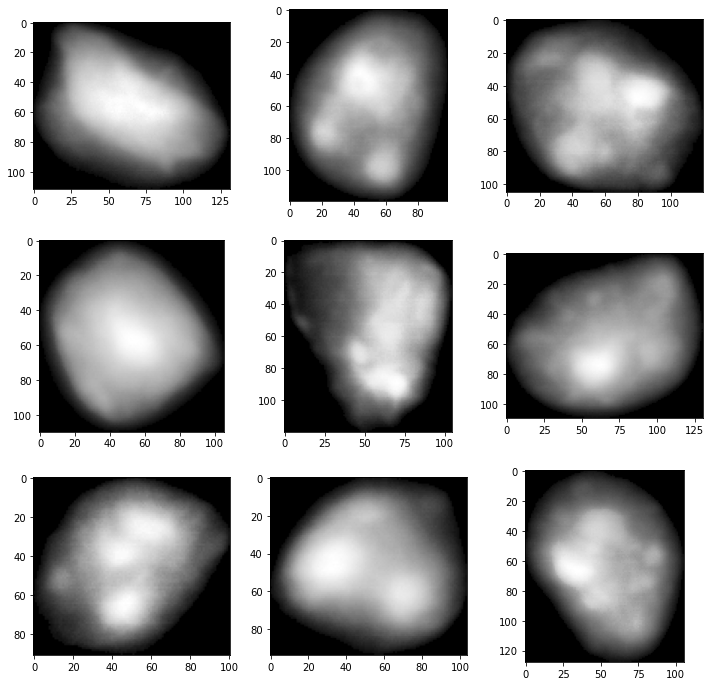

In [108]:
ncols=3
nrows=3
figsize=(12,12)
nexamples=ncols*nrows
index = numpy.random.choice(len(selected_img), size=nexamples, replace=False, p=None)
figure, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
for n in range(nexamples):
    r = int(n / ncols)
    c = numpy.mod(n,ncols)
    axes[r,c].imshow(selected_img[index[n]], cmap='gray')

### Preprocess the patch in the same way as in the main code using crop

In [132]:
min_row, min_col, max_row, max_col = zip(*bbox)

print("->",min_row[:10])
print("->",max_row[:10])
bbox[:10]

-> (17, 140, 176, 187, 216, 329, 396, 401, 518, 548)
-> (116, 291, 292, 313, 336, 442, 545, 515, 638, 700)


[(17, 13078, 116, 13181),
 (140, 12950, 291, 13086),
 (176, 13501, 292, 13618),
 (187, 10785, 313, 10929),
 (216, 13334, 336, 13442),
 (329, 13017, 442, 13140),
 (396, 11114, 545, 11234),
 (401, 12763, 515, 12865),
 (518, 10549, 638, 10650),
 (548, 9319, 700, 9476)]

In [161]:
bounding_box = BB(bx=0.5*(torch.tensor(min_row)+torch.tensor(max_row)).float().unsqueeze(-2),
                  by=0.5*(torch.tensor(min_col)+torch.tensor(max_col)).float().unsqueeze(-2),
                  bw=(torch.tensor(max_row)-torch.tensor(min_row)).float().unsqueeze(-2),
                  bh=(torch.tensor(max_col)-torch.tensor(min_col)).float().unsqueeze(-2))

n_boxes, batch = bounding_box.bx.shape
big_stuff = transforms.ToTensor()(img)[None].float()
print("big_stuff.shape ->",big_stuff.shape)

big_stuff.shape -> torch.Size([1, 1, 21505, 21505])


In [188]:
size = params["architecture"]['cropped_size']
size=56
small_stuff = Cropper().crop(bounding_box, big_stuff[None].expand(n_boxes, batch,-1,-1,-1), width_small=size , height_small=size)[0]
print("small_stuff.shape ->",small_stuff.shape)
    

small_stuff.shape -> torch.Size([1309, 1, 56, 56])


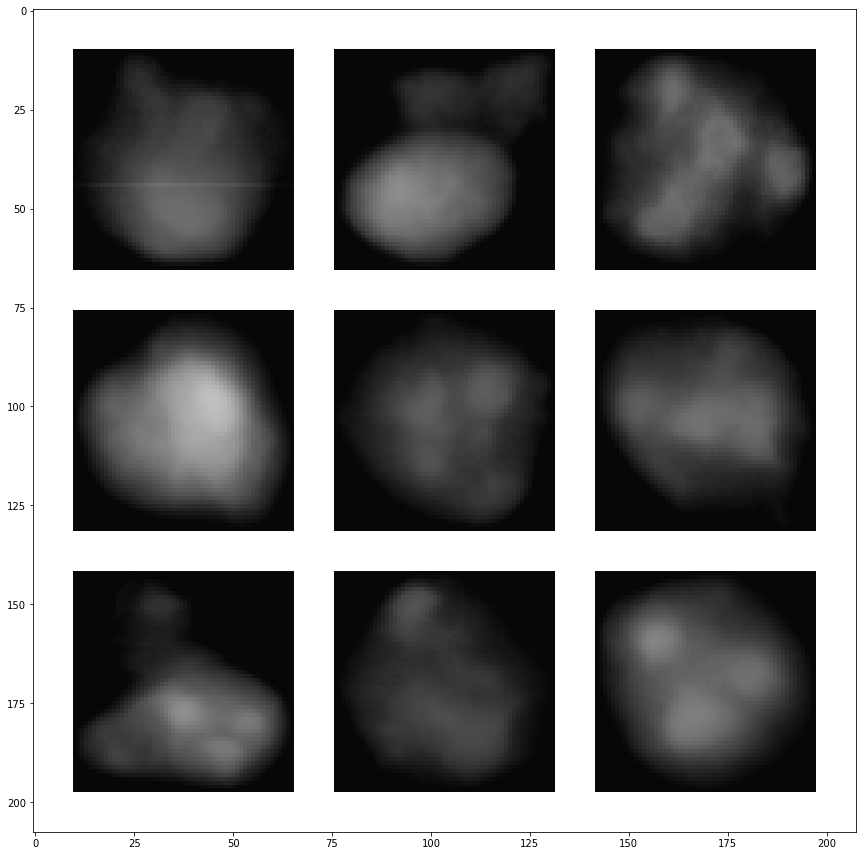

In [189]:
show_batch(small_stuff[:9], n_col=3, figsize=(12,12))

### Compare the two method

before cropping 0.0 0.3731910718665686
after cropping tensor(0.0301) tensor(0.3709)


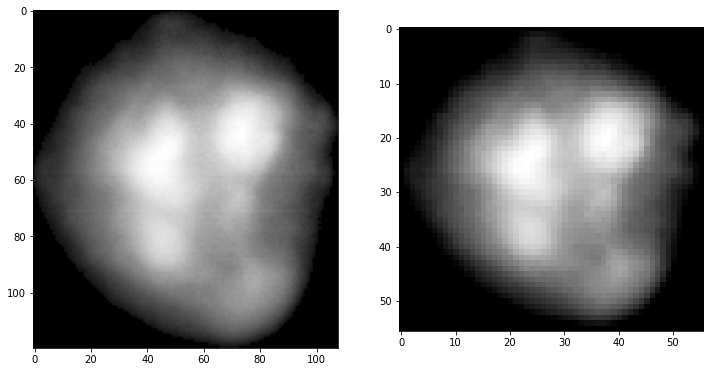

In [190]:
n_chosen=4

figure, axes = plt.subplots(ncols=2, figsize=(12,12))
axes[0].imshow(selected_img[n_chosen], cmap='gray')
axes[1].imshow(small_stuff[n_chosen,0], cmap='gray')
    
print("before cropping",numpy.min(selected_img[n_chosen]), numpy.max(selected_img[n_chosen]))
print("after cropping", torch.min(small_stuff[n_chosen,0]), torch.max(small_stuff[n_chosen,0]))

In [ ]:
PROBLEM OF ANTIALIASING
READ MASK CNN TO SEE HOW THEY DO THE REGION PROPOSAL